In [1]:
import pickle
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [2]:
with open("data_batched.pkl","rb") as f:
    data_dict = pickle.load( f )

In [3]:
num_events = len(data_dict["label_batch"])

train_split = int(0.7 * num_events)
test_split = int(0.75 * num_events)

X_train_jet = data_dict["jet_batch"][0:train_split]
X_train_trk = data_dict["trk_batch"][0:train_split]
y_train = data_dict["label_batch"][0:train_split]
y_trk_train = data_dict["fromDown_Batch"][0:train_split]


X_val_jet = data_dict["jet_batch"][train_split:test_split]
X_val_trk = data_dict["trk_batch"][train_split:test_split]
y_val = data_dict["label_batch"][train_split:test_split]
y_trk_val = data_dict["fromDown_Batch"][train_split:test_split]


X_test_jet = data_dict["jet_batch"][test_split:]
X_test_trk = data_dict["trk_batch"][test_split:]
y_test = data_dict["label_batch"][test_split:]
y_trk_test = data_dict["fromDown_Batch"][test_split:]


print("Training Batches: ", len(y_train))
print("Validation Batches: ", len(y_val))
print("Testing Batches: ", len(y_test))

Training Batches:  151
Validation Batches:  11
Testing Batches:  55


In [4]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

In [5]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 128
        self.num_heads = 8
        self.num_jet_feats = 4
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        # Track Encoder Stack
        self.trk_encoder = Encoder(self.embed_dim, self.num_heads)
        
        # Cross Encoder Stack
        self.cross_encoder = Encoder(self.embed_dim, self.num_heads)
        
        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 8)
        
        # BCE Task
        self.BCE = nn.Linear(self.embed_dim,1)
        
    def forward(self, jets, trks):
        #print(jets.shape)
        #print(trks.shape)
        #print()
        
        # Feature preprocessing layers
        jet_init = F.gelu(self.jet_initializer(jets))
        trk_init = F.gelu(self.trk_initializer(trks))
        
        #print(jet_init.shape)
        #print(trk_init.shape)
        #print()
        
        # All Track Attention
        trk_embedding, trk_weights = self.trk_encoder(trk_init, trk_init, trk_init)
      
        #print(trk_embedding.shape)
        #print()
    
        # Cross Attention
        jet_embedding = torch.unsqueeze(jet_init, 1)
        #print(jet_embedding.shape)
        
        jet_embedding, cross_weights = self.cross_encoder(jet_embedding, trk_embedding, trk_embedding)
        #print(jet_embedding.shape)
        
        # Get output
        output = self.regression(jet_embedding)
        
        fromDown = F.sigmoid(self.BCE(trk_embedding))
        
        return output, fromDown

In [6]:
# ### Define Training Loop
def train(X_train_jet, X_train_trk, y_train, y_trk_train, 
          X_val_jet, X_val_trk, y_val, y_trk_val,
          epochs=40):
    
    alpha=1
    beta=1
    
    combined_history = []
    
    num_train = len(X_train_jet)
    num_val = len(X_val_jet)
    
    step_size=50
    gamma=1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()
            
            output, trk_output = model(X_train_jet[i].to(device), 
                           X_train_trk[i].to(device))
            
            MSE_loss=MSE_loss_fn(output, y_train[i].to(device))
            BCE_loss=BCE_loss_fn(trk_output, y_trk_train[i].to(device))

            loss=MSE_loss*alpha+BCE_loss*beta
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            output, trk_output = model(X_val_jet[i].to(device), 
                           X_val_trk[i].to(device))
            
            MSE_loss=MSE_loss_fn(output, y_val[i].to(device))
            BCE_loss=BCE_loss_fn(trk_output, y_trk_val[i].to(device))

            loss=MSE_loss*alpha+BCE_loss*beta
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
            
        scheduler.step()
            
        cumulative_loss_val = cumulative_loss_val / num_val
        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))
 
        if (e+1)%step_size==0:
            print("\tReducing Step Size by ", gamma)
            
    return np.array(combined_history)

In [7]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

GPU Available:  True
cuda:0



In [8]:
model = Model()
model.to(device)
print("Trainable Parameters :", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable Parameters : 169865


In [9]:
Epochs=100
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
MSE_loss_fn = nn.MSELoss()
BCE_loss_fn = nn.BCELoss()

In [10]:
#%%time
combined_history = train(X_train_jet, X_train_trk, y_train, y_trk_train, 
                         X_val_jet, X_val_trk, y_val, y_trk_val,
                         epochs=Epochs)
torch.save(model,"model.torch")

Epoch: 0 	Train Loss: 48369.727 	Val Loss: 51728.324
Epoch: 1 	Train Loss: 45552.562 	Val Loss: 47973.49
Epoch: 2 	Train Loss: 40982.098 	Val Loss: 42332.566
Epoch: 3 	Train Loss: 35256.33 	Val Loss: 36249.258
Epoch: 4 	Train Loss: 30086.738 	Val Loss: 31497.914
Epoch: 5 	Train Loss: 26608.055 	Val Loss: 28489.533
Epoch: 6 	Train Loss: 24305.027 	Val Loss: 26156.54
Epoch: 7 	Train Loss: 22298.088 	Val Loss: 23943.137
Epoch: 8 	Train Loss: 20316.408 	Val Loss: 21764.17
Epoch: 9 	Train Loss: 18394.27 	Val Loss: 19680.486
Epoch: 10 	Train Loss: 16604.7 	Val Loss: 17768.346
Epoch: 11 	Train Loss: 14995.019 	Val Loss: 16067.678
Epoch: 12 	Train Loss: 13582.267 	Val Loss: 14583.972
Epoch: 13 	Train Loss: 12380.009 	Val Loss: 13324.106
Epoch: 14 	Train Loss: 11377.532 	Val Loss: 12268.91
Epoch: 15 	Train Loss: 10569.193 	Val Loss: 11412.915
Epoch: 16 	Train Loss: 9944.489 	Val Loss: 10761.441
Epoch: 17 	Train Loss: 9462.8955 	Val Loss: 10228.363
Epoch: 18 	Train Loss: 9124.331 	Val Loss: 9859

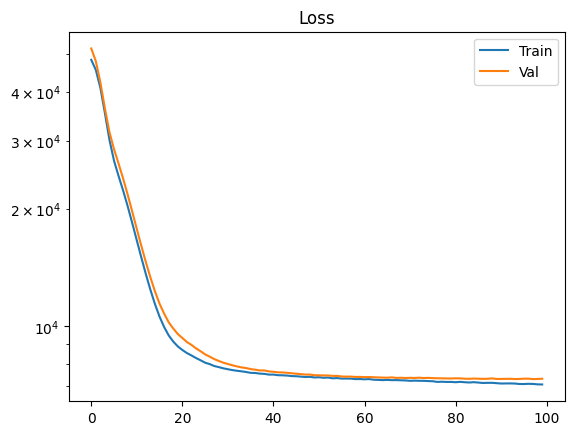

In [11]:
plt.figure()
plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.yscale('log')
plt.savefig("Loss_Curve.png")
plt.show()

In [12]:
# ### Evaluate Model

model.eval()
cumulative_loss_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []
loss_fn = nn.MSELoss()

predicted_labels = np.array([]).reshape(0,1,8)
true_labels = np.array([]).reshape(0,1,8)

pred_trk_labels = []
true_trk_labels = []

trk_pt = []

num_test = len(X_test_jet)
for i in range(num_test):
    output, trk_output = model(X_test_jet[i].to(device), 
                               X_test_trk[i].to(device))
    
    MSE_loss=MSE_loss_fn(output, y_test[i].to(device))
    BCE_loss=BCE_loss_fn(trk_output, y_trk_test[i].to(device))

    loss=MSE_loss+BCE_loss
    
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
      
    predicted_labels = np.vstack((predicted_labels,output.detach().cpu().numpy()))
    true_labels = np.vstack((true_labels,y_test[i].detach().cpu().numpy()))
    
    pred_trk_labels.append(np.ravel(trk_output.detach().cpu().numpy()))
    true_trk_labels.append(np.ravel(y_trk_test[i].detach().cpu().numpy()))
    
    trk_pt.append(np.ravel(X_test_trk[i].detach().cpu().numpy()[:,:,0]))
    
cumulative_loss_test = cumulative_loss_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(np.ravel(true_labels), np.ravel(predicted_labels)))
print("Test RMSE:\t", root_mean_squared_error(np.ravel(true_labels), np.ravel(predicted_labels)))

Train Loss:	 7077.4917
Val Loss:	 7321.192
Test Loss:	 8205.775

Test MAE:	 51.282754875908964
Test RMSE:	 90.58261963252033


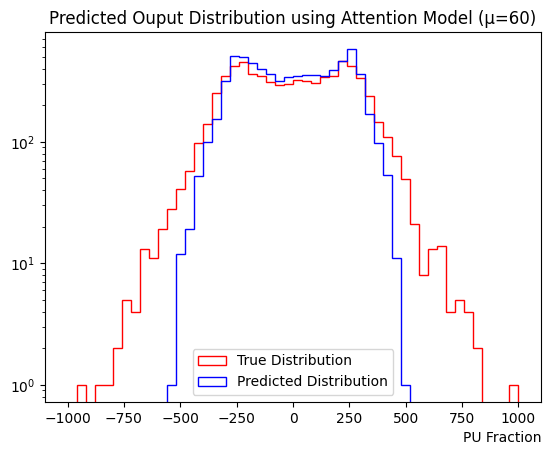

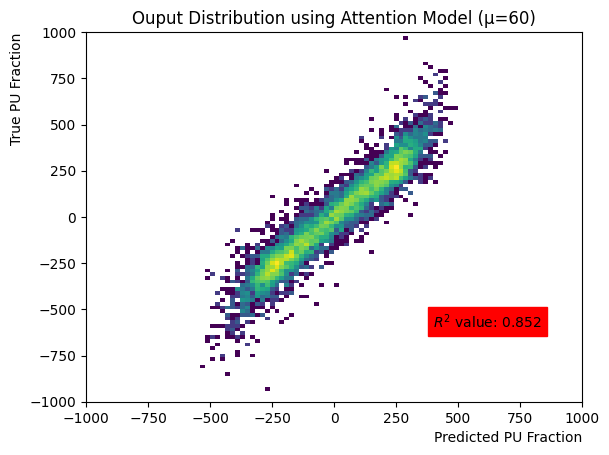

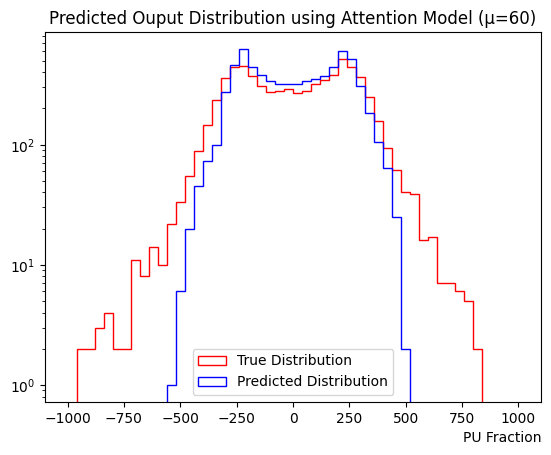

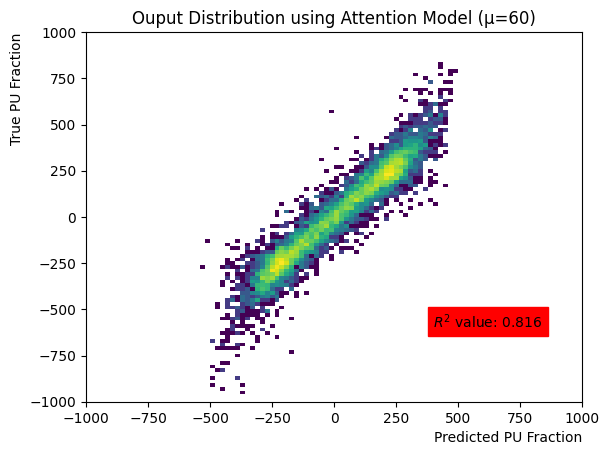

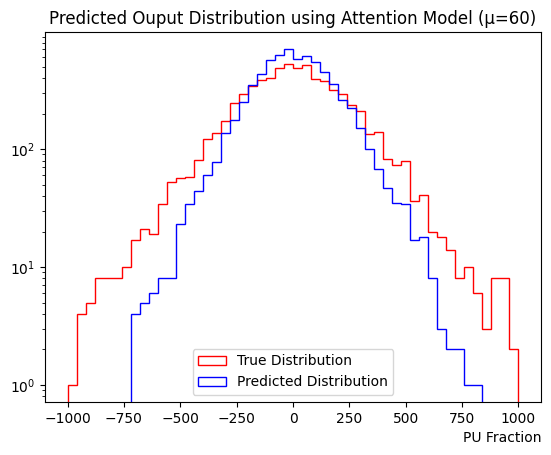

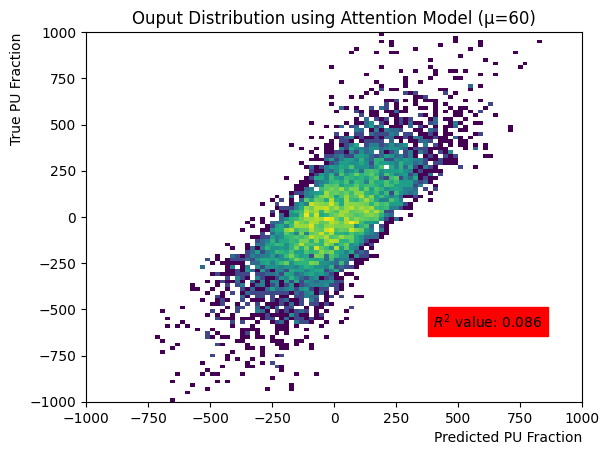

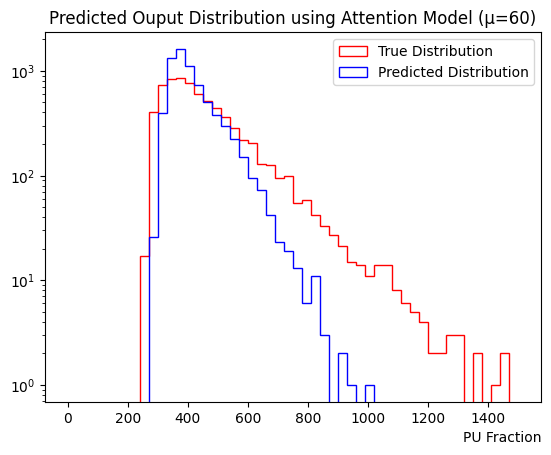

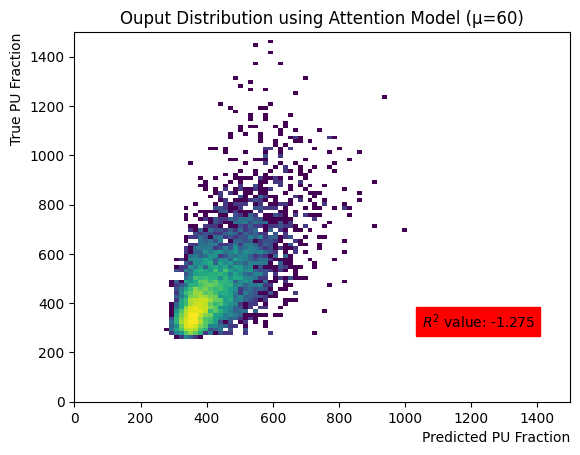

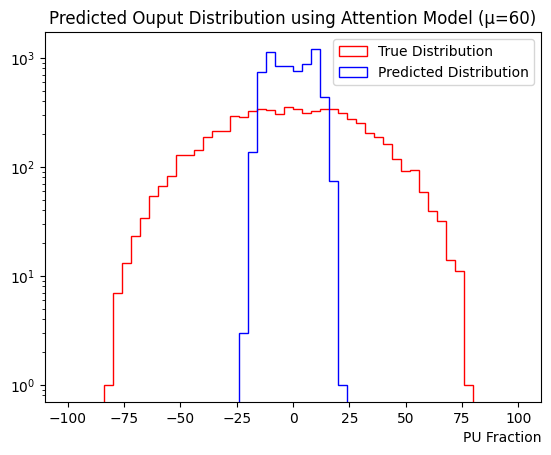

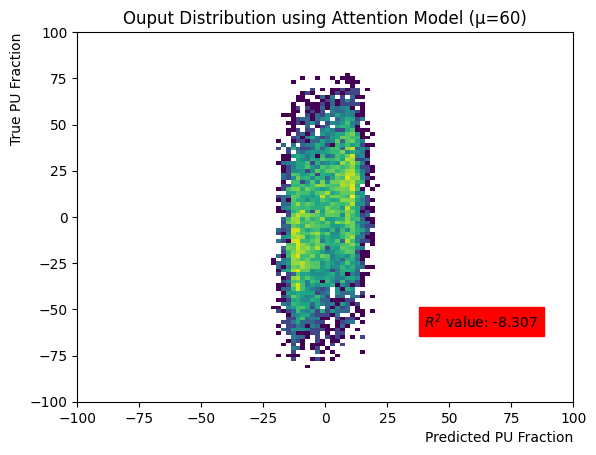

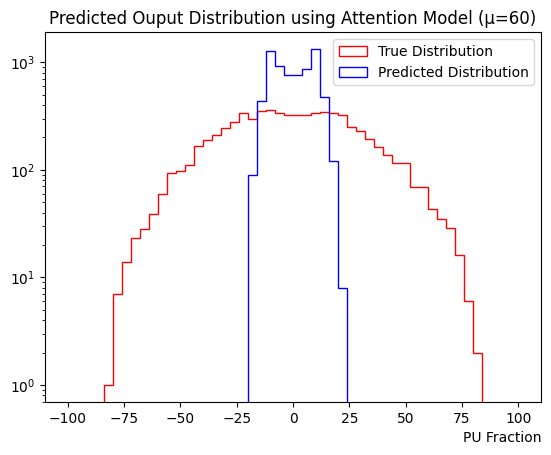

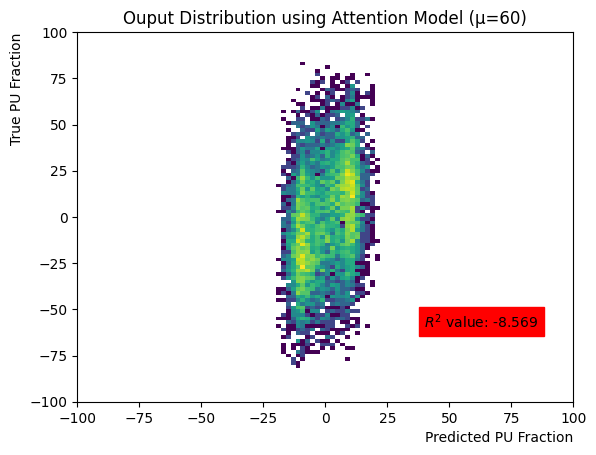

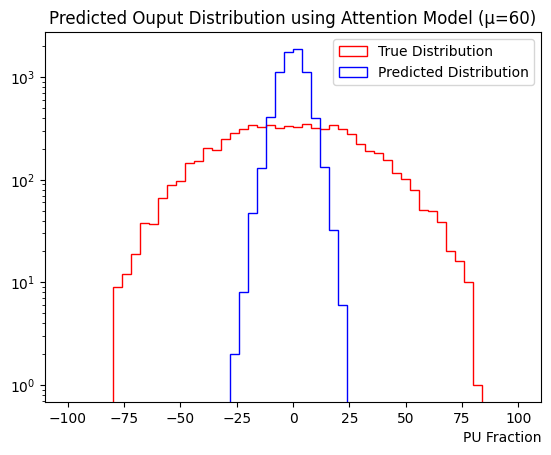

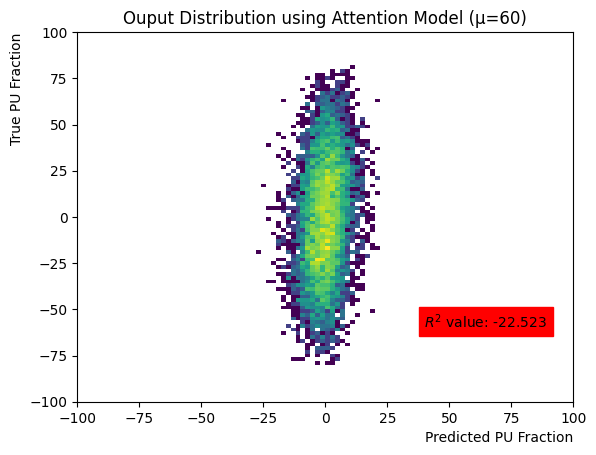

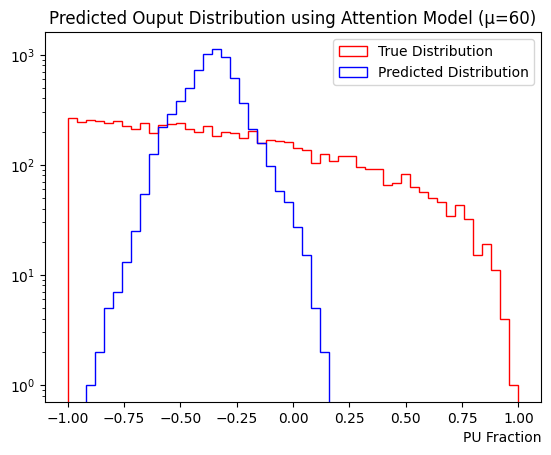

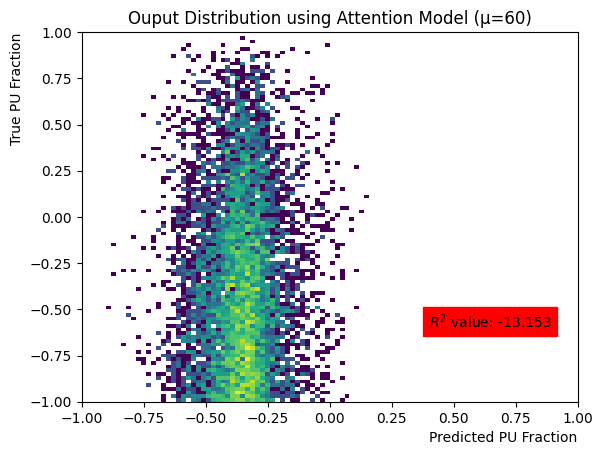

In [13]:
num_feats = len(true_labels[0][0])

ranges = [(-1000,1000),(-1000,1000),(-1000,1000),(0,1500),(-100,100),(-100,100),(-100,100),(-1,1)]

for i in range(num_feats):
    plt.figure()
    plt.hist(np.ravel(true_labels[:,:,i]),histtype='step',color='r',label='True Distribution',bins=50,range=ranges[i])
    plt.hist(np.ravel(predicted_labels[:,:,i]),histtype='step',color='b',label='Predicted Distribution',bins=50,range=ranges[i])
    plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('PU Fraction',loc='right')
    plt.savefig("pred_1d.png")
    plt.show()

    plt.figure()
    plt.title("Ouput Distribution using Attention Model (\u03BC=60)")
    plt.hist2d(np.ravel(predicted_labels[:,:,i]),np.ravel(true_labels[:,:,i]), bins=100,norm=mcolors.LogNorm(),range=(ranges[i],ranges[i]))
    plt.xlabel('Predicted PU Fraction',loc='right')
    plt.ylabel('True PU Fraction',loc='top')
    plt.savefig("pred_2d.png")
    diff = ranges[i][1] - ranges[i][0]
    plt.text(ranges[i][1]-0.3*diff,ranges[i][0]+0.2*diff,"$R^2$ value: "+str(round(r2_score(np.ravel(predicted_labels[:,:,i]),np.ravel(true_labels[:,:,i])),3)),backgroundcolor='r',color='k')
    #print("R^2 value: ", round(r2_score(predicted_labels[:,i],true_labels[:,i]),3))
    plt.show()

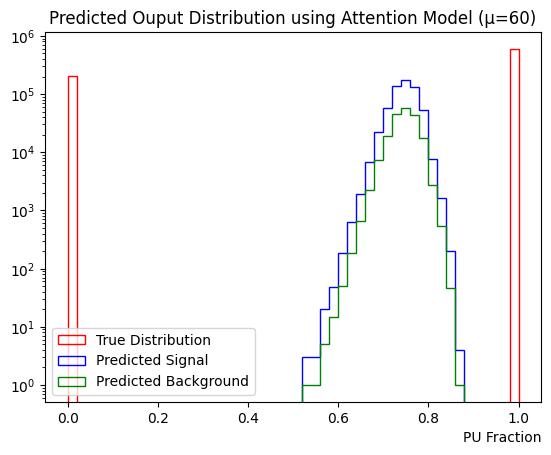

In [14]:
true_trk_labels = ak.ravel(true_trk_labels)
pred_trk_labels = ak.ravel(pred_trk_labels)

trk_pt = ak.ravel(trk_pt)

pad = trk_pt!=0

sig = true_trk_labels==1
sig = sig & pad

bkg= ~sig & pad

plt.figure()
plt.hist(true_trk_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(pred_trk_labels[sig],histtype='step',color='b',label='Predicted Signal',bins=50,range=(0,1))
plt.hist(pred_trk_labels[bkg],histtype='step',color='g',label='Predicted Background',bins=50,range=(0,1))

plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.savefig("pred_1d.png")
plt.show()